In [17]:
from gurobipy import *
from utils import (get_parameters, generate_mapping_names, generate_mapping_qualifications,
                   generate_qualifications_matrix, generate_working_days_matrix,
                   generate_working_days_per_qualification_matrix, generate_due_dates_matrix,
                   generate_gains_vect, generate_penalties_vect)
from display_utils import print_plannings
from lp_utils import (generate_variables_and_constraints, set_objective_and_solve,
                      add_epsilon_constraint, solve_epsilon_constraint, run_epsilon_constraint,
                     is_pareto_efficient,filter_pareto_front)

In [2]:
import json
with open('instances/instances_given/toy_instance.json') as f:
    json_instance = json.load(f)
    f.close()

In [3]:
json_instance

{'horizon': 5,
 'qualifications': ['A', 'B', 'C'],
 'staff': [{'name': 'Olivia',
   'qualifications': ['A', 'B', 'C'],
   'vacations': []},
  {'name': 'Liam', 'qualifications': ['A', 'B'], 'vacations': [1]},
  {'name': 'Emma', 'qualifications': ['C'], 'vacations': [2]}],
 'jobs': [{'name': 'Job1',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 1, 'C': 1}},
  {'name': 'Job2',
   'gain': 15,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'B': 2}},
  {'name': 'Job3',
   'gain': 15,
   'due_date': 4,
   'daily_penalty': 3,
   'working_days_per_qualification': {'A': 1, 'C': 2}},
  {'name': 'Job4',
   'gain': 20,
   'due_date': 3,
   'daily_penalty': 3,
   'working_days_per_qualification': {'B': 2, 'C': 1}},
  {'name': 'Job5',
   'gain': 10,
   'due_date': 5,
   'daily_penalty': 3,
   'working_days_per_qualification': {'C': 2}}]}

In [4]:
N,M,K,T = get_parameters(json_instance)

In [5]:
mapping_names = generate_mapping_names(json_instance)
mapping_qualif = generate_mapping_qualifications(json_instance)
qualifications_mat = generate_qualifications_matrix(json_instance,mapping_qualif,N,K)
working_days_mat = generate_working_days_matrix(json_instance,N,T)
wd_per_qual_mat = generate_working_days_per_qualification_matrix(json_instance, mapping_qualif, M, K)
due_dates_mat = generate_due_dates_matrix(json_instance, M, T)
gains_vect = generate_gains_vect(json_instance, M)
penalties_vect = generate_penalties_vect(json_instance, M)

In [6]:
m = generate_variables_and_constraints(N,M,K,T,qualifications_mat, working_days_mat, wd_per_qual_mat)
                

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-11


## Resolution du programme monobjectif maximisant le gain obtenu

In [7]:
obj1_1,obj2_1,obj3_1 = set_objective_and_solve(m,1,gains_vect,penalties_vect,due_dates_mat,M,T)

In [8]:
print("La valeur optimale de l'objectif de gain est {}".format(obj1_1))
print("Le nombre max de projet/pers et de durée max d'un projet sont alors {} et {}".format(obj2_1,obj3_1))
obj1_opti = obj1_1
print_plannings(N,M,K,T,mapping_names,working_days_mat,json_instance['qualifications'],m)

La valeur optimale de l'objectif de gain est 65
Le nombre max de projet/pers et de durée max d'un projet sont alors 5 et 4
planning de Olivia : 
jour 1 :  projet 4, compétence B

jour 2 :  projet 2, compétence B

jour 3 :  projet 1, compétence B

jour 4 :  projet 3, compétence C

jour 5 :  projet 5, compétence C

planning de Liam : 
jour 1 :  jour de congé

jour 2 :  projet 4, compétence B

jour 3 :  projet 1, compétence A

jour 4 :  projet 3, compétence A

jour 5 :  projet 2, compétence B

planning de Emma : 
jour 1 :  projet 4, compétence C

jour 2 :  jour de congé

jour 3 :  projet 1, compétence C

jour 4 :  projet 3, compétence C

jour 5 :  projet 5, compétence C



## Resolution du programme monobjectif minimisant le nombre maximal de projets affectés à un membre du staff


In [9]:
obj1_2,obj2_2,obj3_2 = set_objective_and_solve(m,2,gains_vect,penalties_vect,due_dates_mat,M,T)

In [10]:
print("La valeur optimale de l'objectif de minimisation du nombre de projets/pers est {}".format(obj2_2))
print("Le gain et la durée max d'un projet sont alors {} et {}".format(obj1_2,obj3_2))
obj2_opti = obj2_2
print_plannings(N,M,K,T,mapping_names,working_days_mat,json_instance['qualifications'],m)

La valeur optimale de l'objectif de minimisation du nombre de projets/pers est 0
Le gain et la durée max d'un projet sont alors 0 et 0
planning de Olivia : 
jour 1 :  
jour 2 :  
jour 3 :  
jour 4 :  
jour 5 :  
planning de Liam : 
jour 1 :  jour de congé

jour 2 :  
jour 3 :  
jour 4 :  
jour 5 :  
planning de Emma : 
jour 1 :  
jour 2 :  jour de congé

jour 3 :  
jour 4 :  
jour 5 :  


## Resolution du programme monobjectif minimisant la durée maximale d'un projet

In [11]:
obj1_3,obj2_3,obj3_3 = set_objective_and_solve(m,3,gains_vect,penalties_vect,due_dates_mat,M,T)

In [12]:
print("La valeur optimale de l'objectif de minimisation de la durée des projets est {}".format(obj3_3))
print("Le gain et le nombre max de projets/pers sont alors {} et {}".format(obj1_3,obj2_3))
obj3_opti = obj2_3
print_plannings(N,M,K,T,mapping_names,working_days_mat,json_instance['qualifications'],m)

La valeur optimale de l'objectif de minimisation de la durée des projets est 0
Le gain et le nombre max de projets/pers sont alors 0 et 0
planning de Olivia : 
jour 1 :  
jour 2 :  
jour 3 :  
jour 4 :  
jour 5 :  
planning de Liam : 
jour 1 :  jour de congé

jour 2 :  
jour 3 :  
jour 4 :  
jour 5 :  
planning de Emma : 
jour 1 :  
jour 2 :  jour de congé

jour 3 :  
jour 4 :  
jour 5 :  


## Génération des solutions efficaces (surface de pareto)

In [13]:
optimal_sol = obj1_opti, obj2_opti, obj3_opti
optimal_sol

(65, 0, 0)

In [14]:
nadir_sol = (0,M,T)
nadir_sol

(0, 5, 5)

In [15]:
pareto_surface_non_filtered, epsilon_constraints = run_epsilon_constraint(m,optimal_sol,nadir_sol,gains_vect,penalties_vect,due_dates_mat,M,T)

step with eps2 = 5 and eps3 = 5
solution found :  [-65, 5, 1]
step with eps2 = 5 and eps3 = 0
solution found :  [-59, 5, 0]
step with eps2 = 4 and eps3 = 5
solution found :  [-59, 4, 0]
step with eps2 = 3 and eps3 = 5
solution found :  [-49, 3, 0]
step with eps2 = 2 and eps3 = 5
solution found :  [-37, 2, 0]
step with eps2 = 1 and eps3 = 5
solution found :  [-20, 1, 0]
step with eps2 = 0 and eps3 = 5
solution found :  [0, 0, 0]


In [20]:
mask = is_pareto_efficient(pareto_surface_non_filtered)
pareto_surface = filter_pareto_front(pareto_surface_non_filtered,mask)
epsilon_cstr = epsilon_constraints[mask]

In [21]:
pareto_surface

array([[65,  5,  1],
       [59,  4,  0],
       [49,  3,  0],
       [37,  2,  0],
       [20,  1,  0],
       [ 0,  0,  0]])

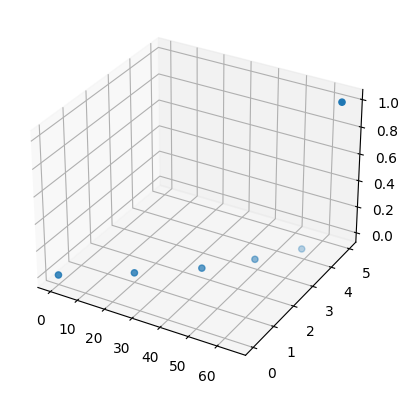

In [22]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')

x_data = [t[0] for t in pareto_surface]
y_data = [t[1] for t in pareto_surface]
z_data = [t[2] for t in pareto_surface]
ax.scatter3D(x_data,y_data,z_data)

In [67]:
for eps in epsilon_cstr :
    solve_epsilon_constraint_prog(eps, verbose=True)

planning for eps2 = 4 and eps3 = 0
planning de Olivia : 
jour 1 :  projet 5, compétence C
jour 2 :  jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence C
jour 5 :  projet 1, compétence B
planning de Liam : 
jour 1 :  jour de congé
jour 2 :  jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence A
jour 5 :  projet 1, compétence A
planning de Emma : 
jour 1 :  projet 5, compétence C
jour 2 :  jour de congé
jour 3 :  projet 4, compétence C
jour 4 :  projet 3, compétence C
jour 5 :  projet 1, compétence C
planning for eps2 = 3 and eps3 = 1
planning de Olivia : 
jour 1 :  projet 1, compétence A
jour 2 :  projet 1, compétence B
jour 3 :  projet 3, compétence C
jour 4 :  projet 3, compétence C
jour 5 :  projet 5, compétence C
planning de Liam : 
jour 1 :  jour de congé
jour 2 :  projet 4, compétence B
jour 3 :  projet 4, compétence B
jour 4 :  projet 3, compétence A
jour 5 :  projet 2, compétence B
planning de Emma : 
jour 1 :  projet 1, compétence C
jour 2 :  jour de con

In [30]:
def infer_preference_model(inacceptable, correct, satisfaisant):
    # Instanciation du modèle
    m = Model("PL inference préférences")

    # Vecteur de variables
    w = m.addVars(3,name="w",lb=0, ub=1)
    l = m.addVar(name="lambda",lb=0.5,ub=1)

    m.update()
    
    m.addConstrs((quicksum([w[i] for i in range(3) if inacceptable[m][i]>=correct[n][i] ]) <= l-1e-6 for m in range(len(inacceptable)) for n in range(len(correct)) ), name="comparaison innacceptable et correct")
    m.addConstrs((quicksum([w[i] for i in range(3) if inacceptable[m][i]>=satisfaisant[n][i] ]) <= l-1e-6 for m in range(len(inacceptable)) for n in range(len(satisfaisant))), name="comparaison innacceptable et satisfaisant")
    m.addConstrs((quicksum([w[i] for i in range(3) if correct[m][i]>=satisfaisant[n][i] ]) <= l-1e-6 for m in range(len(correct)) for n in range(len(satisfaisant)) ), name="comparaison correct et satisfaisant")
    m.addConstr(quicksum([w[i] for i in range(3)])==1)
    m.addConstr(l <= 1-1e-8)
    
    obj = l
    m.setObjective(obj, GRB.MINIMIZE)

    # Paramétrage (mode mute)
    m.params.outputflag = 0

    # Résolution du PL
    m.optimize()
    
    if m.status == GRB.INFEASIBLE :
        raise Exception('no solution')
    
    return (m.objVal, [v.X for v in w.values()])


In [224]:


pareto_surface = np.abs(pareto_surface)

def generate_dominance_mat(w,lam):
    dominance_mat = np.zeros((len(pareto_surface),len(pareto_surface)))
    for i in range(len(pareto_surface)):
        for j in range(len(pareto_surface)):
            if i != j :
                print(f'comparing a{i+1} and a{j+1}')
                x = pareto_surface[i]
                y = pareto_surface[j]
                s = np.sum([w[k] for k in range(3) if x[k] >= y[k]])
                if s >= lam :
                    dominance_mat[i,j]=1
                    print(f'a{i+1} domine a{j+1}')
                else :
                    print(f'a{i+1} ne domine pas a{j+1}')
                print('====================')
    return dominance_mat


In [225]:
generate_dominance_mat(np.array([0.2, 0.4, 0.4]),1)

comparing a1 and a2
a1 ne domine pas a2
comparing a1 and a3
a1 domine a3
comparing a1 and a4
a1 ne domine pas a4
comparing a1 and a5
a1 ne domine pas a5
comparing a1 and a6
a1 domine a6
comparing a1 and a7
a1 ne domine pas a7
comparing a1 and a8
a1 ne domine pas a8
comparing a1 and a9
a1 domine a9
comparing a1 and a10
a1 domine a10
comparing a2 and a1
a2 ne domine pas a1
comparing a2 and a3
a2 domine a3
comparing a2 and a4
a2 ne domine pas a4
comparing a2 and a5
a2 domine a5
comparing a2 and a6
a2 domine a6
comparing a2 and a7
a2 ne domine pas a7
comparing a2 and a8
a2 domine a8
comparing a2 and a9
a2 domine a9
comparing a2 and a10
a2 domine a10
comparing a3 and a1
a3 ne domine pas a1
comparing a3 and a2
a3 ne domine pas a2
comparing a3 and a4
a3 ne domine pas a4
comparing a3 and a5
a3 ne domine pas a5
comparing a3 and a6
a3 domine a6
comparing a3 and a7
a3 ne domine pas a7
comparing a3 and a8
a3 ne domine pas a8
comparing a3 and a9
a3 domine a9
comparing a3 and a10
a3 domine a10
compa

array([[0., 0., 1., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [238]:
inacceptable = pareto_surface[[5,7,9]]
correct = pareto_surface[[0,2,4,6]]
satisfaisant = pareto_surface[[1,3]]



#infer_preference_model(inacceptable,correct,satisfaisant)

In [239]:
print(inacceptable)
print(correct)
print(satisfaisant)

[[37.  2.  0.]
 [30.  1.  1.]
 [ 0.  0.  0.]]
[[59.  4.  0.]
 [49.  3.  0.]
 [55.  2.  1.]
 [42.  1.  2.]]
[[65.  3.  1.]
 [65.  2.  2.]]


In [240]:
def predict_class(inacceptable, correct, satisfaisant,remaining_actions):
    action_classes = dict()
    for a in remaining_actions :
        action_classes[tuple(a)] = []
        try :
            print(infer_preference_model(np.concatenate((inacceptable,a.reshape(1,3))),correct,satisfaisant))
            action_classes[tuple(a)].append('inacceptable')
        except :
            pass
        try :
            print(infer_preference_model(inacceptable,np.concatenate((correct,a.reshape(1,3))),satisfaisant))
            action_classes[tuple(a)].append('correct')
        except :
            pass
        try :
            print(infer_preference_model(inacceptable,correct,np.concatenate((satisfaisant,a.reshape(1,3)))))
            action_classes[tuple(a)].append('satisfaisant')
        except :
            pass
    return action_classes
        
        
        
    

In [241]:
predict_class(inacceptable,correct,satisfaisant, [pareto_surface[8]])

(0.5, [1.0, 0.0, 0.0])


{(20.0, 1.0, 0.0): ['inacceptable']}